
Enter a polynomial:  (x+1)^2 + (2+x)^3


[(x + 1)**2, (x + 2)**3]
[x, 1]
[x, 1]
[2, x]
[2, x]
[2, x]


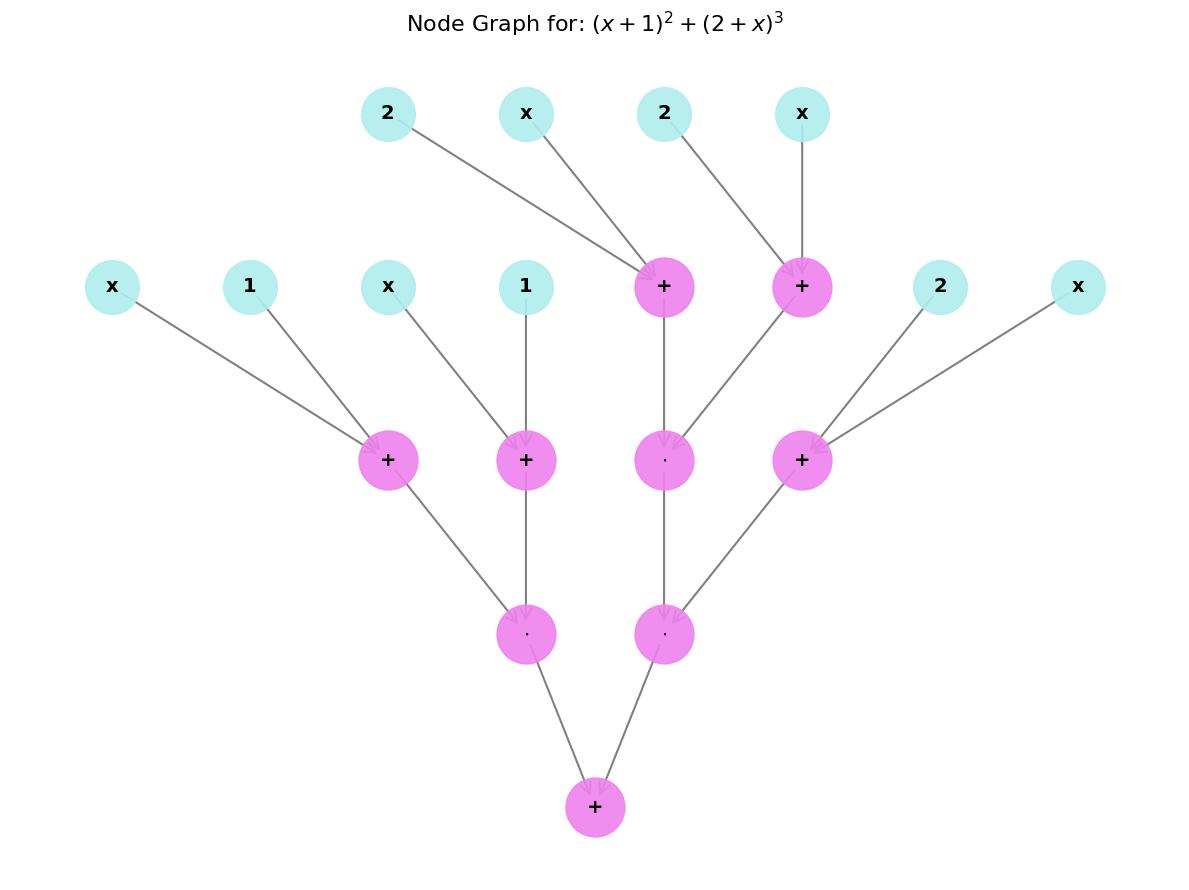

Successfully visualized: (x+1)**2 + (2+x)**3


In [35]:
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr
import numpy as np


# Parse a sympy expression and build a node graph showing operations
def create_node_graph(expr):
    graph = nx.DiGraph()
    node_id = 0
    node_id, root_id = process_expression(expr, graph, node_id)
    return graph, root_id


# Process the expression recursively
def process_expression(expr, graph, node_id, parent_id=None):
    if isinstance(expr, sp.Add) or isinstance(expr, sp.Mul):
        label = "+" if isinstance(expr, sp.Add) else r"$\cdot$"
        args = list(expr.args)

        #Creates a binary tree
        left_expr = args[0]
        node_id, left_id = process_expression(left_expr, graph, node_id)

        for expr_branch in args[1:]:
            parent_node = node_id
            graph.add_node(parent_node, label=label, type="operation")
            node_id += 1

            # Connect to the parent node
            if parent_id is not None:
                graph.add_edge(parent_node, parent_id)
                parent_id = parent_node 

            # Left branch
            graph.add_edge(left_id, parent_node)

            # Right branch
            node_id, right_id = process_expression(expr_branch, graph, node_id)
            graph.add_edge(right_id, parent_node)

            left_id = parent_node  # for chaining

        return node_id, left_id

    elif isinstance(expr, sp.Pow):
        base, exp = expr.args
        #Assumes that exponent is an integer
        if exp.is_Integer and exp > 1:
            #Creates a binary tree
            node_id, left_id = process_expression(base, graph, node_id)
            for _ in range(exp - 1):
                mul_node = node_id
                graph.add_node(mul_node, label=r"$\cdot$", type="operation")
                node_id += 1

                node_id, right_id = process_expression(base, graph, node_id)

                graph.add_edge(left_id, mul_node)
                graph.add_edge(right_id, mul_node)

                left_id = mul_node

            if parent_id is not None:
                graph.add_edge(left_id, parent_id)

            return node_id, left_id


    elif isinstance(expr, sp.Symbol):
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id

    elif expr.is_number:
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id




def custom_layout(G, root):
    pos = {}
    
    rev_G = G.reverse()
    
    levels = {root: 0}
    queue = [root]
    while queue:
        node = queue.pop(0)
        for neighbor in rev_G.neighbors(node):
            if neighbor not in levels:
                levels[neighbor] = levels[node] + 1
                queue.append(neighbor)
    
    # Group nodes by level
    nodes_by_level = {}
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)
    
    for level in nodes_by_level:
        nodes_by_level[level].sort(key=lambda n: (G.nodes[n].get('type', ''), G.nodes[n].get('label', '')))
    
    max_level = max(levels.values()) if levels else 0
    for level, nodes in nodes_by_level.items():
        num_nodes = len(nodes)
        for i, node in enumerate(sorted(nodes)):
            x = (i - (num_nodes - 1) / 2) * 1.5
            y = level 
            pos[node] = (x, y)
    
    return pos



def visualize_polynomial(polynomial_str):
    # Parse the expression
    expr = parse_expr(polynomial_str, evaluate=False)
    graph, root_id = create_node_graph(expr)
    node_labels = nx.get_node_attributes(graph, 'label')
    pos = custom_layout(graph, root_id)
    
    plt.figure(figsize=(12, 9))
    
    #Divide up the nodes
    operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
    value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

    
    # Draw operation nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, 
                        node_size=1800, node_color='violet', alpha=0.9)
    
    # Draw value nodes
    nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes,
                        node_size=1500, node_color='paleturquoise', alpha=0.9)
    
    # Draw the edges with correct arrow direction
    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', 
                          arrowsize=20, width=1.5, edge_color='gray')
    
    # Draw node labels
    node_id_labels = {node: str(node) for node in graph.nodes()}
    #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
    nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')
    
    plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Successfully visualized: {polynomial_str}")
    


user_input = input("\nEnter a polynomial: ")

if user_input.strip():
    user_input = user_input.replace('^', '**')
    visualize_polynomial(user_input)
